In [1]:
# Importing necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from datasets.fashionmnist_dataset import FashionMNISTDataset
from models.alexnet_model import AlexNetModel
from training.optimization_loop import OptimizationLoop
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Check if a GPU is available and set the device accordingly
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
# Initialize the model, loss function, and optimizer
print("Initializing the model, loss function, and optimizer...")
model = AlexNetModel().to(device)

Initializing the model, loss function, and optimizer...


In [ ]:
# Define hyperparameters
learning_rate = 1e-3
epochs = 50
batch_size=32

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()  

# Define optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# Define the experiment name
experiment_name = "alexnet_fashionmnist_pytorch_ce_adam"

In [5]:
# Read the training and validation datasets into DataFrames
train_data_df = pd.read_csv('datasets/fashion-mnist/fashion-mnist_train.csv')

print(train_data_df.shape)

(60000, 785)


In [6]:
# Separate images and labels
X_train_original = train_data_df.iloc[:, 1:].values # All columns except the first (label)
y_train_original = train_data_df.iloc[:, 0].values # First column (label)

print(f"X_train shape: {X_train_original.shape}, y_train shape: {y_train_original.shape}")

X_train shape: (60000, 784), y_train shape: (60000,)


In [7]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_original, y_train_original, test_size=0.2, random_state=42) # 20% for validation

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (48000, 784), y_train shape: (48000,)
X_val shape: (12000, 784), y_val shape: (12000,)


In [8]:
# Load the training and validation datasets
train_dataset = FashionMNISTDataset(np.column_stack((y_train, X_train)), transform=transform)
validate_dataset = FashionMNISTDataset(np.column_stack((y_val, X_val)), transform=transform)

In [9]:
# Create DataLoaders for the datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# First, grab a single mini-batch of images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# print the shape of images and labels
print(images.shape, labels.shape)

torch.Size([32, 1, 227, 227]) torch.Size([32])


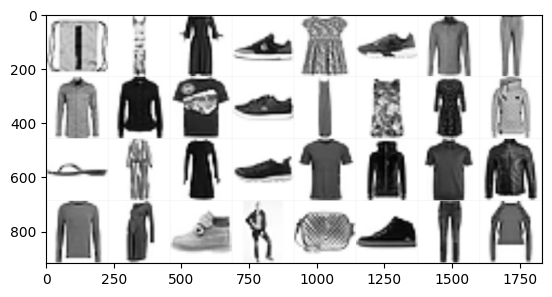

In [11]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Create a grid from the batch of images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [ ]:
# Create SummaryWriter for TensorBoard logging
writer = SummaryWriter('runs/' + experiment_name)

# Move the images and labels to the device
images, labels = images.to(device), labels.to(device)

# Write image data to TensorBoard log dir
writer.add_image('Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

In [ ]:
# Visualizing the Model

# Print the model summary
print("Model Summary:")
print(model)

# add_graph() will trace the sample input through the model,
# and render it as a graph.
writer.add_graph(model, images)
writer.flush()

In [ ]:
# Print to total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

In [ ]:
 # Print the loss function and optimizer
print("Loss function:", loss_fn)
print("Optimizer:", optimizer)

In [ ]:
# Train the model
print("Starting training...")
optimizationLoop = OptimizationLoop(model, loss_fn, device)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = optimizationLoop.train_loop(train_dataloader, optimizer)
    eval_loss, eval_accuracy = optimizationLoop.evaluate_loop(validate_dataloader)

    # Log the training and evaluation loss to TensorBoard
    print('Epoch:', t+1, 'Training loss:', train_loss, 'Evaluation loss:', eval_loss, 'Accuracy:', eval_accuracy)
    writer.add_scalars('Training vs Evaluation Loss', {'Training': train_loss, 'Evaluation': eval_loss}, t+1)
    writer.add_scalar('Training Accuracy', eval_accuracy, t+1)
    writer.flush()
print("Training complete.")